In [1]:
%pylab inline
import numpy as np
import cPickle as pickle
import irm
import sklearn.metrics
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
import sys
sys.path.append("../")
import exputil
reload(exputil)

ERROR (theano.sandbox.cuda): nvcc compiler not found on $PATH. Check your nvcc installation and try again.
ERROR:theano.sandbox.cuda:nvcc compiler not found on $PATH. Check your nvcc installation and try again.


Populating the interactive namespace from numpy and matplotlib


<module 'exputil' from '../exputil.pyc'>

In [2]:
neurons_data = pickle.load(open("../data/mushroombody.neurondf.pickle", 'r'))
synapse_data = pickle.load(open("../data/mushroombody.synapsesdf.pickle", 'r'))
basicmat_data = pickle.load(open("../data/mushroombody.cleandata.pickle", 'r'))
tbar_df = synapse_data['tbar_df']
connections_df = synapse_data['connections_df']
neurons_df = neurons_data['neurondf']


In [3]:
tgt_cell_name = "MBON-07-B"
exp_filename = "bbnonconj_1000_th40_{}".format(tgt_cell_name)
filename_base = "sbm kc-kc results analysis.{}.{}".format(exp_filename, tgt_cell_name)

a = pickle.load(open("../dist.out/{}.results.pickle".format(exp_filename), 'r'))


In [4]:
job_res = a['job_res']
infiles = a['infiles']
all_exp = a['all_exp']

In [5]:
cv_data = pickle.load(open("../" + infiles[0], 'r'))
conmat = cv_data['conmat']
cvs = cv_data['cvs']

In [6]:
infiles[0]

'data/KC-rosette-KC.MBON-07-B.40.0.cv_10.pickle'

In [7]:
len(job_res)

100

In [8]:

df = exputil.compute_stats(job_res, cvs, conmat)

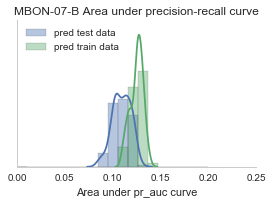

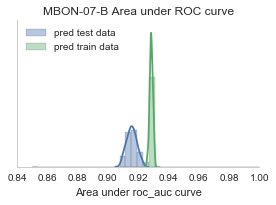

In [10]:

variables = {'pr_auc' : ('precision-recall', np.linspace(0, 0.2, 20)), 
             'roc_auc' : ('ROC',np.linspace(0.85, 1.0, 40))}
for var_key, var_conf in variables.iteritems():
    var_name = var_conf[0]
    bins = var_conf[1]
    
    fig = pylab.figure(figsize=(4, 3))
    ax = fig.add_subplot(1, 1, 1)
    for gi, g in df.groupby('observed'):
        #sns.distplot(g.roc_auc, bins=bins)
        if gi:
            label = "pred train data"
        else:
            label = "pred test data"
        sns.distplot(g[var_key], bins=bins, label=label)
    sns.despine()
    ax.set_xlabel("Area under {} curve".format(var_key))
    ax.grid(False)
    #ax.set_xlim(0.0, 0.20)
    #ax.set_xticks([0, 0.05, 0.10, 0.15, 0.2])
    ax.set_yticks([])
    pylab.legend(loc="upper left")
    ax.set_title("{} Area under {} curve".format(tgt_cell_name, var_name))
    fig.tight_layout()
    fig.savefig(filename_base + ".{}_hist.pdf".format(var_key))        

In [11]:
all_assign = []
for ji, j in enumerate(job_res):
    filename, cv_i, seed, res = j
    score, state, log, _ = res
    ass = state['domains']['d1']['assignment']
    all_assign.append(ass)
assignments = np.array(all_assign)

In [72]:
per_chain_stats_df = []
for ji, j in enumerate(job_res):
    filename, cv_i, seed, res = j
    score, state, log, _ = res
    
    d = {}
    d['cv_i'] = cv_i
    d['seed'] = seed
    d['score'] = score
    d['runtimes'] = log
    d['state'] = state
    d['last_score'] = scores[-1]
    
    alpha = state['domains']['d1']['hps']['alpha']
    d['crp_alpha'] = alpha
    
    alpha = state['relations']['R1']['hps']['alpha']

    d['R1_alpha'] = alpha
    
    beta = state['relations']['R1']['hps']['beta']
    d['R1_beta'] = beta
    
    per_chain_stats_df.append(d)
    
per_chain_stats_df = pd.DataFrame(per_chain_stats_df)



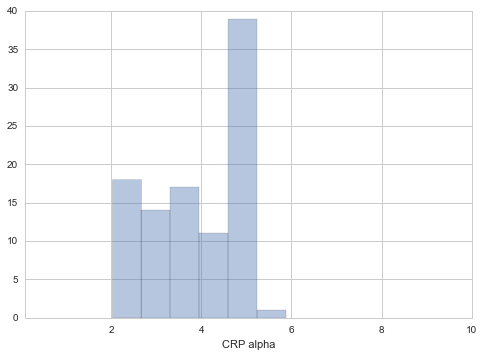

In [71]:

sns.distplot(per_chain_stats_df.crp_alpha, kde=False)
pylab.xlabel("CRP alpha")
pylab.xlim(0.1, 10.0)
pylab.savefig(filename_base + ".crp_alpha_hist.pdf")        

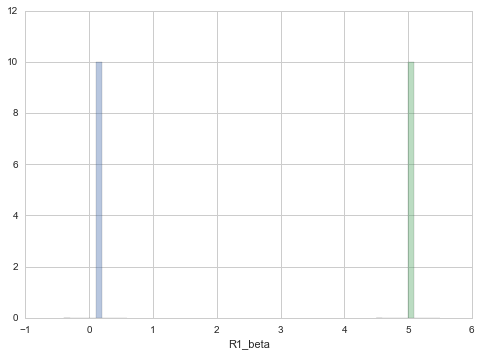

In [77]:

sns.distplot(per_chain_stats_df.R1_alpha, label='alpha')
sns.distplot(per_chain_stats_df.R1_beta, label='beta')

#pylab.xlabel("R1 alpha")
#pylab.xlim(0.1, 10.0)
pylab.savefig(filename_base + ".r1_hp_hist.pdf")        

/data/jonas/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


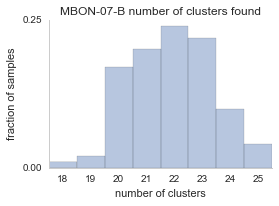

In [14]:

fig = pylab.figure(figsize=(4, 3))
ax = fig.add_subplot(1, 1, 1)

cluster_sizes = [len(np.unique(a)) for a in assignments]
bins = np.arange(np.min(cluster_sizes), np.max(cluster_sizes)+1)
sns.distplot(cluster_sizes, kde=False, bins=bins, norm_hist=True)

ax.grid(False)
#ax.set_xlim(0.0, 0.20)
#ax.set_xticks([0, 0.05, 0.10, 0.15, 0.2])
ax.set_yticks([0, 0.25])
pylab.legend(loc="upper left")
ax.set_title("{} Area under {} curve".format(tgt_cell_name, var_name))
fig.savefig(filename_base + ".{}_hist.pdf".format(var_key))      
ax.set_xticks(bins[:-1] + 0.5)
ax.set_xticklabels(bins[:-1])
ax.set_ylabel("fraction of samples")
pylab.xlabel("number of clusters")
pylab.title("{} number of clusters found".format(tgt_cell_name))
fig.tight_layout()
sns.despine()
fig.savefig(filename_base + ".cluster_number.pdf")        

In [15]:
source_cv = pickle.load(open("../" + infiles[0], 'r')) # assume only one! 

In [16]:
source_cv.keys()


['convergent_only',
 'conmat',
 'cvs',
 'rosette_thold',
 'mat_infile',
 'pre_ids_to_pos',
 'pre_ids_order',
 'infile']

In [17]:
# WE WERE SO STUPID and didn't include this in the generated data
THRESHOLD = source_cv['rosette_thold']
CONVERGENT = source_cv['convergent_only']

d = pickle.load(open("../data/mushroombody.KC-rosette-KC.mats.pickle", 'r'))

a = d['all_results'][(THRESHOLD, CONVERGENT)]

pre_ids_to_pos = d['pre_ids_to_pos']
pre_ids_order = d['pre_ids_order']

In [18]:
pos_to_pre_id = {v : k for k, v in pre_ids_to_pos.iteritems()}

In [19]:

pos_to_name = {}
for pos, pre_id in pos_to_pre_id.iteritems():
    a = neurons_df[neurons_df['body ID'] == pre_id].iloc[0]
    pos_to_name[pos] = a['name']
pre_name_order = np.unique(pos_to_name.values())
name_color_id = {v : k for k, v in enumerate(pre_name_order)}                 

In [20]:
pre_name_order

array(['KC-alpha prime', 'KC-any', 'KC-c', 'KC-p', 'KC-s', 'non-KC'], 
      dtype='|S14')

In [21]:
print pd.value_counts(pos_to_name.values())

KC-s              467
KC-c              257
KC-any            147
KC-alpha prime     85
KC-p               78
non-KC              3
dtype: int64


In [22]:
palette = sns.color_palette("hls", 6)


In [23]:
truth = [name_color_id[pos_to_name[o]] for o in range(len(pos_to_name))]


In [25]:
zm = exputil.compute_zmatrix(assignments)


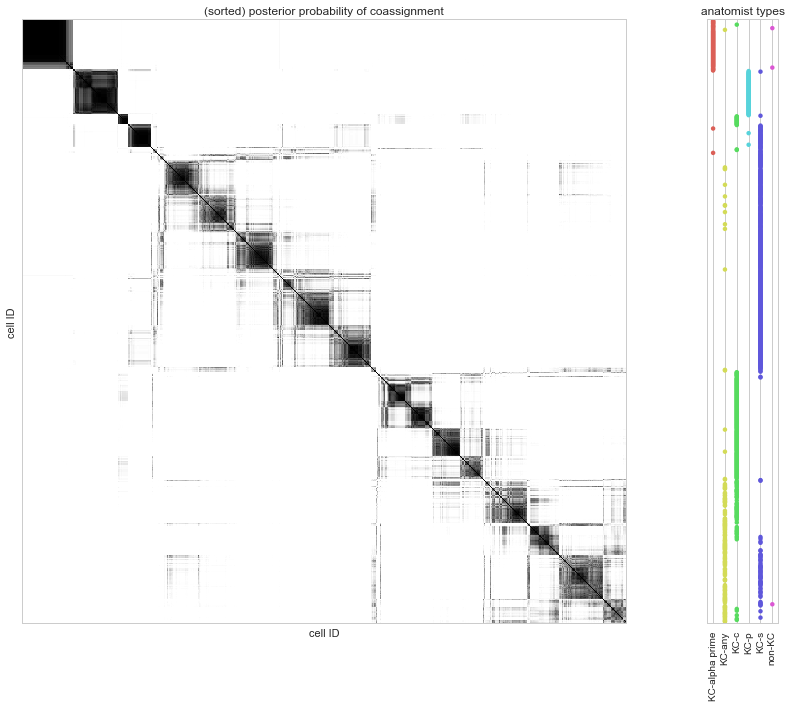

In [26]:
# compare to existing types
import matplotlib.gridspec as gridspec


fig = pylab.figure(figsize=(12, 10))
gs = gridspec.GridSpec(1, 2,
                       width_ratios=[10,1],
                       height_ratios=[1]
                       )

ax_z = pylab.subplot(gs[0])
ax_z.grid(False)
ax_z.set_title("(sorted) posterior probability of coassignment")
ax_z.set_ylabel("cell ID")
ax_z.set_xlabel("cell ID")
ax_z.set_xticks([])
ax_z.set_yticks([])
order = irm.plot.plot_zmatrix(ax_z, zm)

ax_true = pylab.subplot(gs[1])
reordered_truth = [name_color_id[pos_to_name[o]] for o in order]
ax_true.scatter( reordered_truth, range(len(order)), c=[palette[c] for c in reordered_truth], edgecolor='none')
ax_true.set_ylim(len(order)+2, -2)
ax_true.set_xlim(-0.5, 5.5)
ax_true.set_yticks([])
ax_true.set_xticks(range(len(pre_name_order)))
ax_true.set_xticklabels(pre_name_order, rotation=90)
ax_true.set_title("anatomist types")
#fig.suptitle("{} coassignment matrix and ground truth".format(tgt_cell_name))

fig.tight_layout()
fig.savefig(filename_base + ".z_matrix_with_truth.pdf")   

In [27]:

import scipy.sparse.csgraph

zm_normed = zm/ 100.0


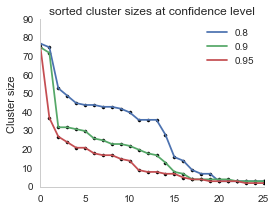

In [28]:
fig =  pylab.figure(figsize=(4, 3))
ax =fig.add_subplot(1, 1, 1)
for thold in [0.8, 0.9, 0.95]:
    zm_filtered = zm_normed > thold
    comps = scipy.sparse.csgraph.connected_components(zm_filtered)

    cluster_counts = np.array(pd.value_counts(comps[1]))
    ax.plot(cluster_counts, label=thold)
    ax.scatter(np.arange(len(cluster_counts)), cluster_counts, c='k', s=10)
ax.set_xlim(0, 25)
sns.despine()
ax.grid(False)
pylab.legend()
ax.set_ylim(bottom=0)
ax.set_ylabel("Cluster size")
ax.set_title("sorted cluster sizes at confidence level")
fig.savefig(filename_base + ".cluster_size_at_conf.pdf")   

In [29]:
for cluster_id, size in pd.value_counts(comps[1]).iteritems():
    ai = np.argwhere(comps[1] == cluster_id).flatten()
    print [pos_to_name[a] for a in ai]

['KC-any', 'KC-c', 'KC-alpha prime', 'KC-alpha prime', 'KC-alpha prime', 'KC-alpha prime', 'KC-alpha prime', 'KC-alpha prime', 'KC-alpha prime', 'KC-alpha prime', 'KC-alpha prime', 'KC-alpha prime', 'KC-alpha prime', 'KC-alpha prime', 'KC-alpha prime', 'KC-alpha prime', 'KC-alpha prime', 'KC-alpha prime', 'KC-alpha prime', 'KC-alpha prime', 'KC-alpha prime', 'KC-alpha prime', 'KC-alpha prime', 'KC-alpha prime', 'KC-alpha prime', 'KC-alpha prime', 'KC-alpha prime', 'KC-alpha prime', 'KC-alpha prime', 'KC-alpha prime', 'KC-alpha prime', 'KC-alpha prime', 'KC-alpha prime', 'KC-alpha prime', 'KC-alpha prime', 'KC-alpha prime', 'KC-alpha prime', 'KC-alpha prime', 'KC-alpha prime', 'KC-alpha prime', 'KC-alpha prime', 'KC-alpha prime', 'KC-alpha prime', 'KC-alpha prime', 'KC-alpha prime', 'KC-alpha prime', 'KC-alpha prime', 'KC-alpha prime', 'KC-alpha prime', 'KC-alpha prime', 'KC-alpha prime', 'KC-alpha prime', 'KC-alpha prime', 'KC-alpha prime', 'KC-alpha prime', 'KC-alpha prime', 'KC-alpha

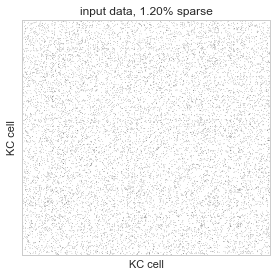

In [30]:
def plot_connectivity_scatter(ax, m, **kwargs):
    nonzeros = np.argwhere(m > 0)
    properties = dict(edgecolor='none', alpha=1, s=1, c='k')
    properties.update(kwargs)
    ax.scatter(nonzeros[:, 0], nonzeros[:, 1], **properties)
    ax.set_xlim(0, m.shape[0])
    ax.set_ylim(m.shape[1], 0)
    
sparsity=  float(np.sum(conmat)) / (conmat.shape[0]*conmat.shape[1])* 100
fig = pylab.figure(figsize=(4, 4))
ax = fig.add_subplot(1, 1, 1)

r = np.random.permutation(conmat.shape[0])
m_in = conmat[r]
m_in = m_in[:, r]
plot_connectivity_scatter(ax, m_in, s=0.2)


ax.set_title("input data, {:3.2f}% sparse".format(sparsity))
ax.set_xlabel("KC cell")
ax.set_xticks([])
ax.set_ylabel("KC cell")
ax.set_yticks([])

fig.tight_layout()
fig.savefig(filename_base + ".conmat.pdf")   

In [31]:
# get the MAP
best_score = -np.inf
best_chain_i = 0
for ji, (filename, cv_i, seed, res) in enumerate(job_res):
    score, state, log, _ = res
    last_score = score[-1]
    if last_score > best_score:
        best_score = last_score
        best_chain_i = ji

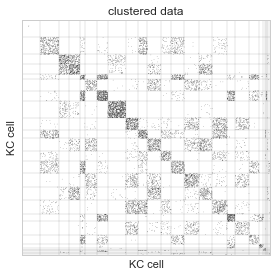

In [32]:
filename, cv_i, seed, res = job_res[best_chain_i]
score, state, log, _ = res
ass = np.array(state['domains']['d1']['assignment'])
ci = np.argsort(ass)
m = conmat[ci]
m = m[:, ci]

edges = np.argwhere(np.diff(ass[ci])> 0)

fig = pylab.figure(figsize=(4, 4))
ax = fig.add_subplot(1, 1, 1)

plot_connectivity_scatter(ax, m , s=0.2)

for e in edges:
    ax.axhline(e, linewidth=0.1, c='k')
    ax.axvline(e, linewidth=0.1, c='k')

ax.set_title("clustered data")
ax.set_xlabel("KC cell")
ax.set_xticks([])
ax.set_ylabel("KC cell")
ax.set_yticks([])
fig.tight_layout()
fig.savefig(filename_base + ".map_sorted.pdf")   

44 0 0 3.28377936967e-05
896 0 0 3.79912999051e-05
896 44 0 0.00174333993345
52983 0 0 0.000306550238747
52983 44 0 0.000566302216612
52983 896 16 0.0552997179329
55643 0 6 0.0221035797149
55643 44 0 1.0399349776e-05
55643 896 0 3.12186998475e-10
55643 52983 0 2.5885036844e-13
56622 0 0 2.54429723817e-15
56622 44 10 0.0341189578176
56622 896 0 0.00115516630467
56622 52983 0 0.00236507900991
56622 55643 0 4.09414205933e-05
57292 0 0 0.000785423442721
57292 44 0 3.60366136931e-09
57292 896 3 0.01071425993
57292 52983 22 0.0734777748585
57292 55643 0 1.690950171e-07
57292 56622 0 3.08008893626e-05
57448 0 0 7.81290143692e-09
57448 44 1 0.00447759497911
57448 896 16 0.0551496967673
57448 52983 2 0.00679996842518
57448 55643 0 3.27269663103e-05
57448 56622 1 0.00576361222193
57448 57292 0 0.00312104821205
85585 0 0 2.3247190839e-09
85585 44 16 0.0551974289119
85585 896 0 1.13200712804e-07
85585 52983 0 6.86384282744e-08
85585 55643 0 1.33231806103e-05
85585 56622 1 0.00529747828841
85585 57

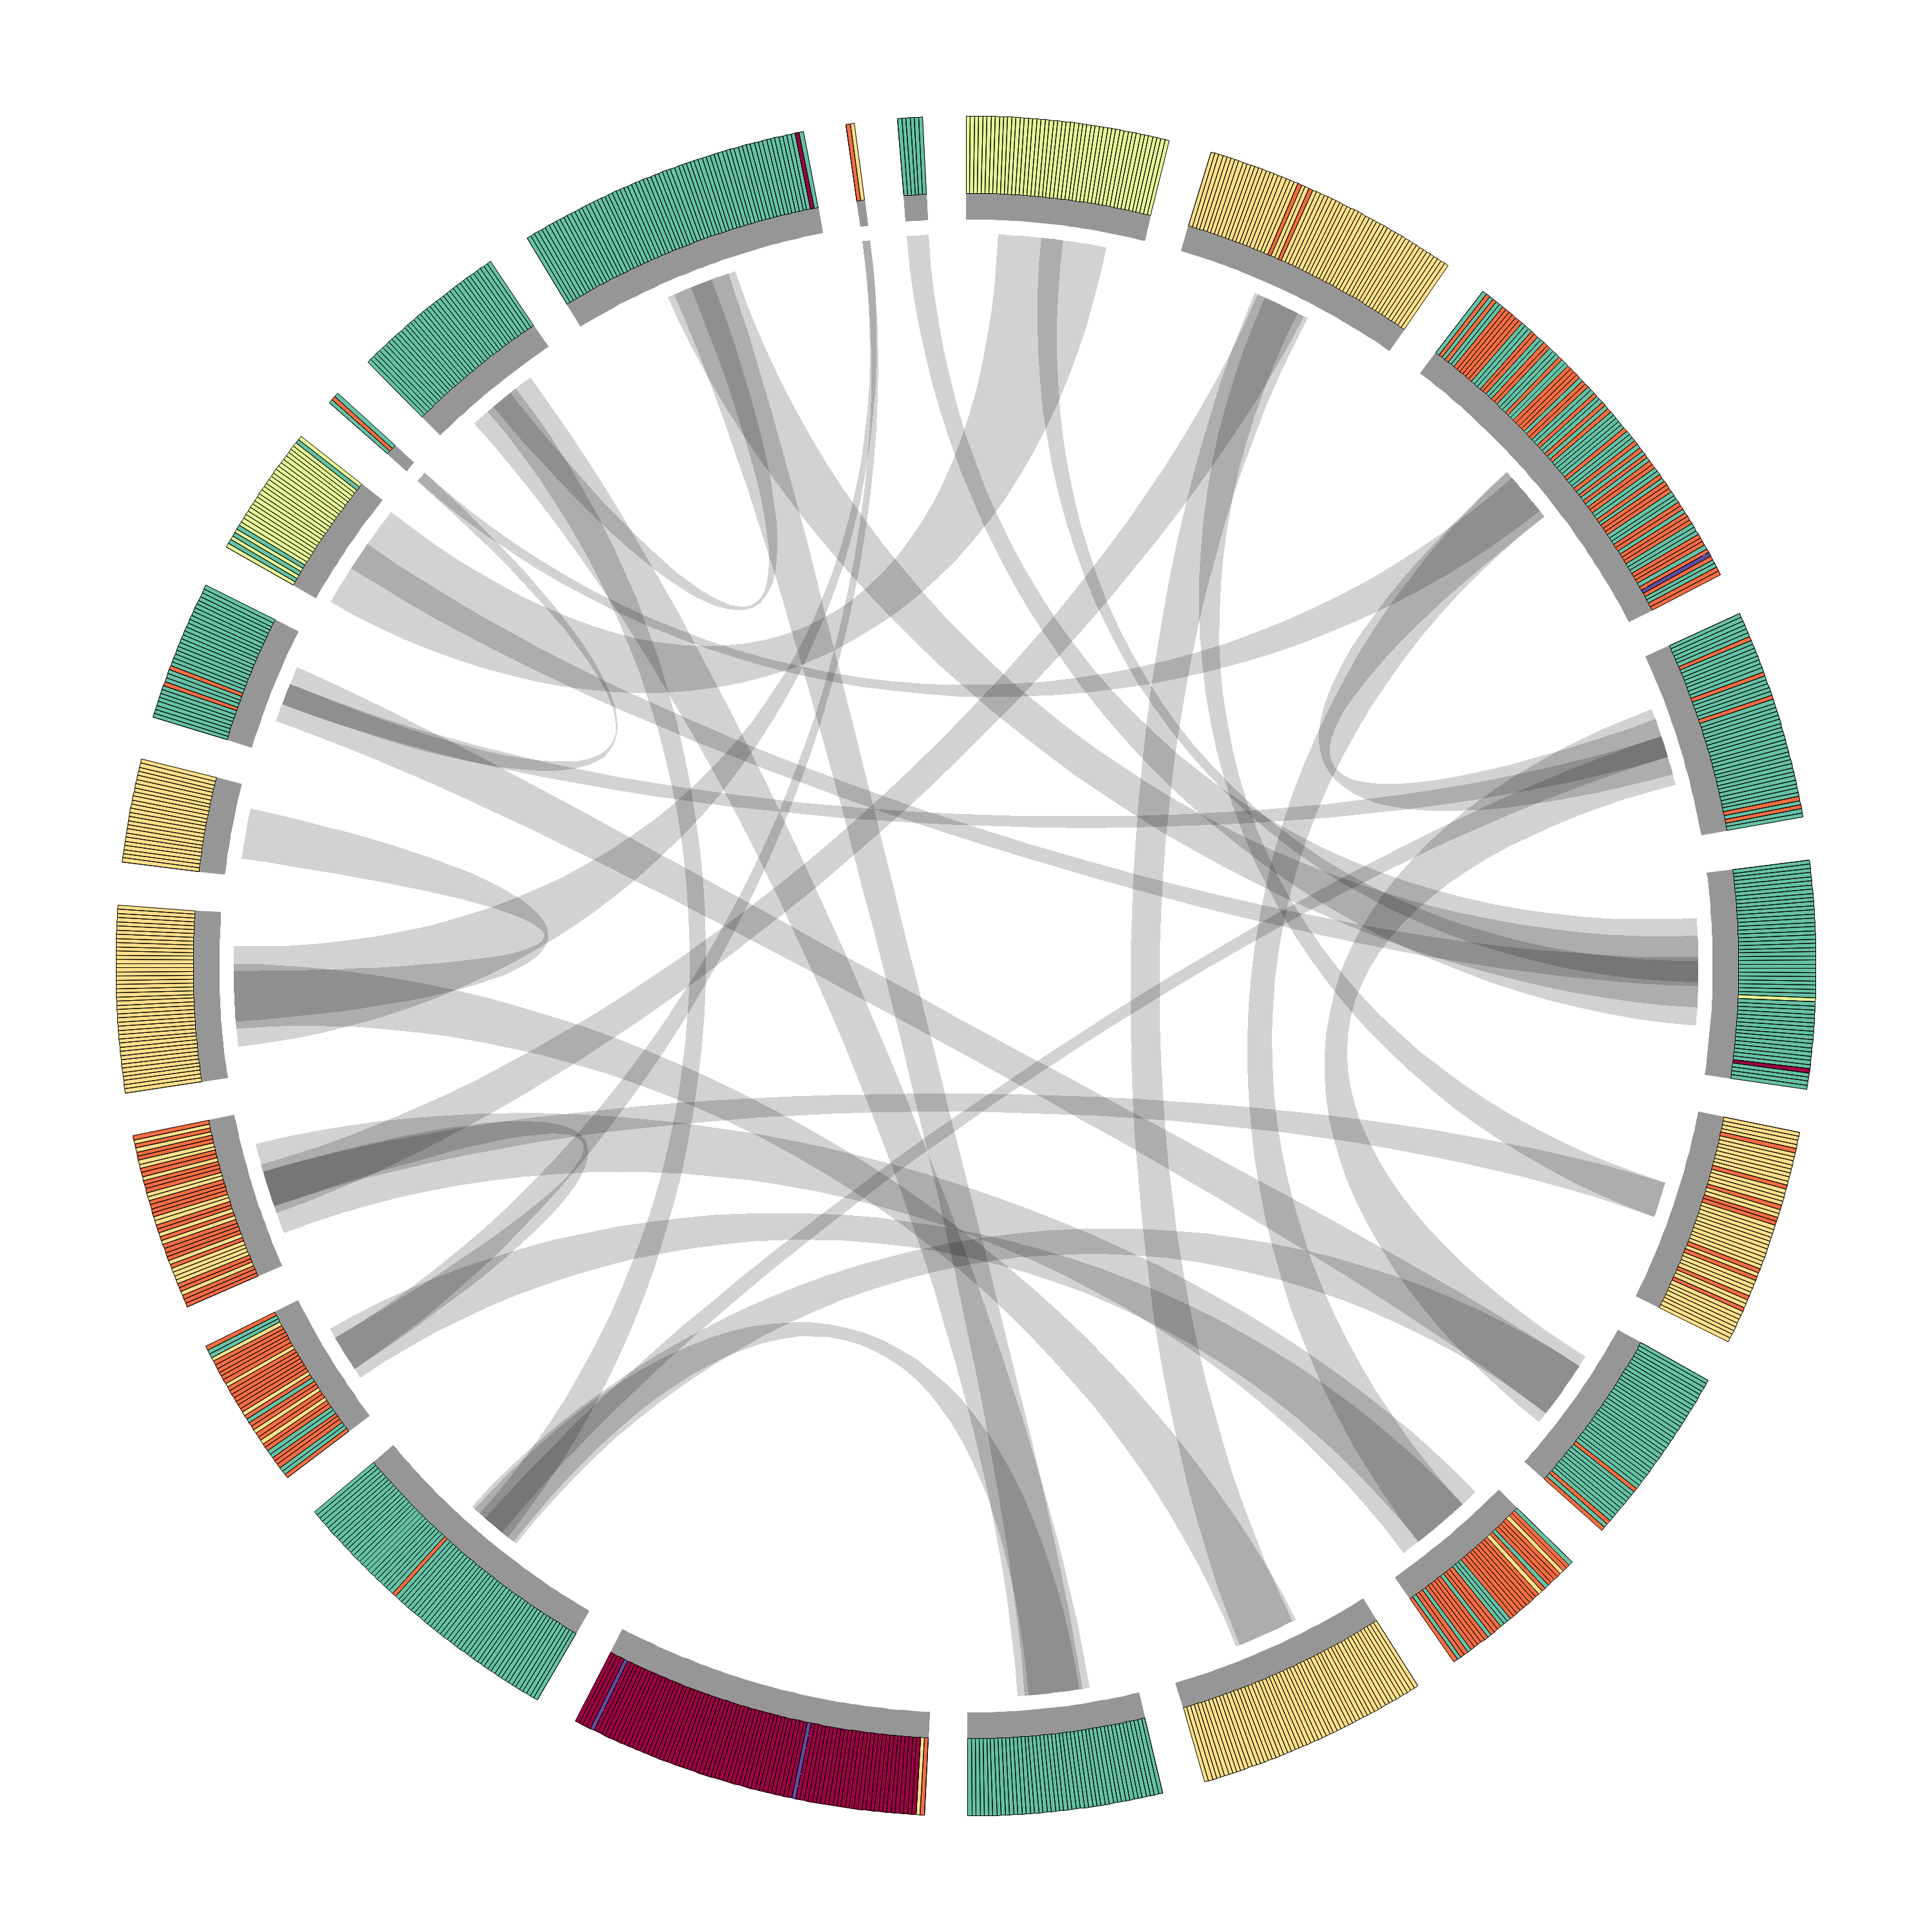

In [78]:
plotCircos = True
img = None
if plotCircos:
    from pycircos import circos
    reload(circos)
    circos.CIRCOS_BIN = "/data/jonas/circos/circos-0.69-3/bin/circos"
    N = 100
    #av = np.arange(N, dtype=np.int32) % 10
    cp = circos.CircosPlot(ass)

    
    ss = state['relations']['R1']['ss']
    ribbons = []
    for c1 in np.unique(ass):
        for c2 in np.unique(ass):
            if c1 > c2:
                width = int(ss[(c1, c2)]['p'] * 300) 
                #print c1, c2, width, ss[(c1, c2)]['p'] 
                if width > 5:
                    ribbons.append((c1, c2, width))
                
    
    cp.set_class_ribbons(ribbons)
    cp.add_plot('heatmap', {'r0' : '1.0r', 
                            'r1' : '1.1r', 
                            'min' : 0, 
                            'max' : 5}, 
                truth, 
                )



    circos.write(cp, 'test.png')
    from IPython.display import Image
    img = Image("test.png")
img

# sufficient statistics comparison


In [33]:
ss = state['relations']['R1']['ss']

N = len(ass)
pred = np.zeros((N, N))
stats = {}

for i in range(N):
    for j in range(N):
        c1 = ass[i]
        c2 = ass[j]
        k = (c1, c2)
        if k not in stats:
            stats[k] = [0, 0]
        stats[k][conmat[i, j]] += 1
        
        c = ss[(c1, c2)]

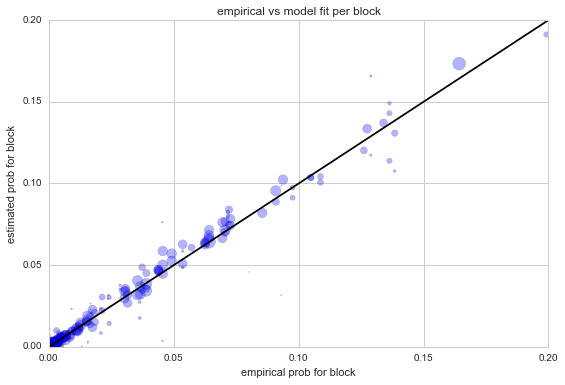

In [34]:
ssdf = []
for k in ss.keys():

    est_prob =  ss[k]['p']
    tails, heads = stats[k]
    n = heads+tails

    emp_prob = heads/float(n)
    ssdf.append({'est_prob': est_prob, 'c1' : k[0], 
                'c2': k[1], 'emp_prob': emp_prob, 
                 'n': n})
ssdf = pd.DataFrame(ssdf)
pylab.scatter(ssdf.emp_prob, ssdf.est_prob, s= ssdf.n*0.03, alpha=0.3)
pylab.xlim(0, 0.2)
pylab.plot([0, 1], [0, 1], c='k')
pylab.ylim(0, 0.2)
pylab.xlabel("empirical prob for block")
pylab.ylabel("estimated prob for block")
pylab.title("empirical vs model fit per block")
pylab.tight_layout()

pylab.savefig(filename_base + ".block_comparison.pdf")   

In [35]:
# what are our cluster sizes
resdf = []
for ji, j in enumerate(job_res):
    filename, cv_i, seed, res = j
    score, state, log, _ = res
    ass = state['domains']['d1']['assignment']
    ca = irm.util.canonicalize_assignment(ass)
    cluster_edges = np.cumsum(irm.util.count(ca).values())
    for e in cluster_edges:
        resdf.append({'cv_i' : cv_i, 'seed' : seed, 'cluster_edge' : e, 'ji': ji})
cluster_sizes_df = pd.DataFrame(resdf)

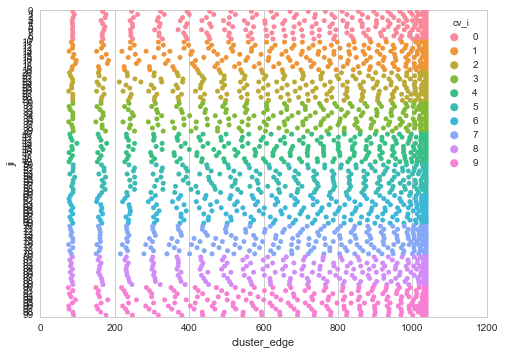

In [36]:
sns.stripplot(x='cluster_edge', y='ji', data=cluster_sizes_df, orient='h', hue='cv_i')
fig.savefig(filename_base + ".cluster_sizes.pdf")   

In [37]:
res = []
assignment_subset = assignments
for i in range(len(assignment_subset)):

        a2 = assignment_subset[i]
        res.append({'i' : i, 
                    'ari' : sklearn.metrics.adjusted_rand_score(truth, a2), 
                    'homogeneity' : sklearn.metrics.homogeneity_score(truth, a2), 
                   'completeness' : sklearn.metrics.completeness_score(truth, a2)})
truth_ari_df = pd.DataFrame(res)


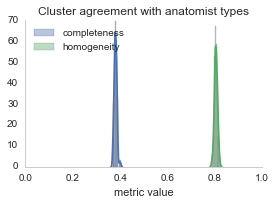

In [38]:

fig = pylab.figure(figsize=(4, 3))
ax = fig.add_subplot(1, 1,1)
#sns.distplot(truth_ari_df.ari, label='ari')
sns.distplot(truth_ari_df.completeness, label='completeness')
sns.distplot(truth_ari_df.homogeneity, label='homogeneity')
ax.set_xlim(0, 1)
ax.set_xlabel('metric value')
ax.grid(False)
pylab.legend(loc='upper left')
ax.set_title("Cluster agreement with anatomist types")
fig.tight_layout()
sns.despine()
fig.savefig(filename_base + ".cluster_metric_anatomist_types.pdf")   

In [39]:
res = []
for i in range(len(assignment_subset)):
    for j in range(len(assignment_subset)):
        if i > j:
            a1 = assignment_subset[i]
            a2 = assignment_subset[j]
            res.append({'i' : i, 'j' : j, 
                        'ari' : sklearn.metrics.adjusted_rand_score(a1, a2), 
                        'homogeneity' : sklearn.metrics.homogeneity_score(a1, a2), 
                       'completeness' : sklearn.metrics.completeness_score(a1, a2)})
sample_ari_df = pd.DataFrame(res)

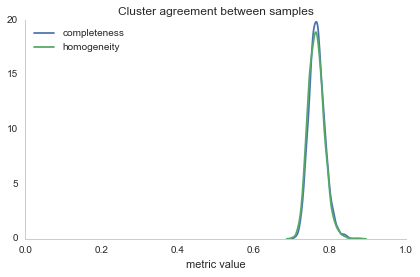

In [40]:

fig = pylab.figure(figsize=(6, 4))
ax = fig.add_subplot(1, 1,1)

#sns.distplot(sample_ari_df.ari)
sns.kdeplot(sample_ari_df.completeness)
sns.kdeplot(sample_ari_df.homogeneity)
ax.set_xlim(0, 1)
ax.set_xlabel('metric value')
ax.grid(False)
pylab.legend(loc='upper left')
ax.set_title("Cluster agreement between samples")
fig.tight_layout()
sns.despine()

fig.savefig(filename_base + ".cluster_metric_internal.pdf")   